In [47]:
%matplotlib inline
import  matplotlib
import matplotlib.pyplot as plt
import pystan

In [48]:
import numpy as np
import scipy.io as sio

In [49]:
df = sio.loadmat('snelson1d.mat')
X = df['X']
Y = df['Y']
X_t = df['tX']
Y_t = df['tY']

In [50]:
stan_code_rff = """
functions{
    vector gp_rff_pred_rng(vector x, vector y, vector x_star, matrix A, matrix phi, vector omega, real ps, real sigma, real jitter){

        int N = rows(y);
        int M = rows(omega);
        int N_star = rows(x_star);
        vector[N_star] f_star;
        matrix[N_star, N_star] f_star_cov;

        {
            vector[N_star] f_star_mean;
            matrix[N_star, M] cosfeats_star;
            matrix[N_star, M] sinfeats_star;
            matrix[N_star, M] feats_star; 
            matrix[N_star, 2*M] phi_star;
            matrix[2*M, 2*M]A_inv;
            vector[2*M] A_inv_phi_y;
            matrix[2*M, N_star] A_inv_phi_star;

            vector[2*M]phi_y = phi'*y;

            feats_star = x_star*omega'*ps;

            for(i in 1:N_star){
                 for(j in 1:M){
                     cosfeats_star[i,j] = cos(feats_star[i,j] );
                     sinfeats_star[i,j] = sin(feats_star[i,j] );
                     phi_star[i,j] = cosfeats_star[i,j];
                     phi_star[i,M+j] = sinfeats_star[i,j];
                }
            }

           A_inv = inverse(A);

           A_inv_phi_y = A_inv* phi_y;
#            f_star_mean = phi_star*A_inv_phi_y;
           
           f_star_mean = phi_star*A_inv_phi_y*(1./M);
           A_inv_phi_star = A_inv * phi_star';

           f_star_cov = square(sigma)*phi_star*A_inv_phi_star;
           for(i in 1:N_star){
                f_star[i] = normal_rng(f_star_mean[i], f_star_cov[i,i]);
           }
           
           
        }

       return f_star;
    }
}

data {
    int<lower=1> N;
    int<lower=1> M;
    int<lower=1> N_star;
    vector[N] x;
    vector[N] y;
    vector[N_star] x_star;
    
}

transformed data {
    real jitter = 1e-6;
    real scale;
    vector[N] f_mean = rep_vector(0, N);
    vector[M] omega; 

    scale = sqrt(2.0/M);

    for (i in 1:M){
        omega[i] = normal_rng(0,1);
    }

}

parameters{
    vector[M] b1;
    vector[M] b2;
    real<lower=0> ps;
    vector[M] bk;
    real<lower=1e-6> sigma;

}

transformed parameters {
    vector[N] f;
#     matrix[N, N] K;
    matrix[N, M] feats;
    matrix[2*M, 2*M] A;
    matrix[N, 2*M] fullfeats;
    
    { 
        matrix[N, M] cosfeats;
        matrix[N, M] sinfeats;
        vector[N] cosfeats_shift;
        vector[N] sinfeats_shift;
        feats = x * omega' * ps;

         for(i in 1:N){
             for(j in 1:M){
                 cosfeats[i,j] = cos(feats[i,j] );
                 sinfeats[i,j] = sin(feats[i,j] );
                 fullfeats[i,j] = cosfeats[i,j];
                 fullfeats[i,M+j] = sinfeats[i,j];
             }
         }

        cosfeats_shift = cosfeats * b1;
        sinfeats_shift = sinfeats * b2;
        f = (cosfeats_shift + cosfeats_shift)*scale;
        A = fullfeats'*fullfeats*square(scale);
        for(i in 1:2*M){
            A[i,i] = A[i,i] + M*square(sigma);
        }

    }
}

model {
    ps ~ normal(0, 1.0);
    bk ~ normal(0,1);
    b1 ~ normal(0.0, 1.0);
    b2 ~ normal(0.0, 1.0);
    sigma ~ normal(0.0, 0.5);
    
    y ~ normal(f, sigma);
    
}

generated quantities{
    vector[N_star] f_star = gp_rff_pred_rng(x, y, x_star, A, fullfeats, omega, ps, sigma, jitter);
    vector[N_star] y_star;
    for(i in 1:N_star){
        y_star[i] = normal_rng(f_star[i], sigma);
    }

}
"""

In [51]:
stan_model_rff = pystan.StanModel(model_code=stan_code_rff)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ac8cd9fa6532a95aa9f7c0494eef4663 NOW.


In [52]:
N_star = 25
X_star = np.linspace(-0.5, 6.5, N_star)[:, None]

In [53]:
gp_snelson_data = {'N':200, 'x':X.flatten(), 'y':Y.flatten(), 'M':20, 'N_star':N_star, 'x_star':X_star.flatten()}

In [54]:
fit_gpr_rff = stan_model_rff.sampling(data=gp_snelson_data, iter=1200, chains=2)

/u/26/dhakaa1/unix/anaconda2/envs/stanpy35/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [55]:
# print(fit_gpr_rff)

In [56]:
samples = fit_gpr_rff.extract(permuted=True)
# omega = samples['sigvar']
# omega_mean = np.mean(omega, axis=0)
# sigma = samples['sigma']
# sigma_mean = np.mean(sigma, axis=0)

In [57]:
f = samples['f']

In [58]:
f_star = samples['f_star']
y_star = samples['y_star']

In [59]:
f_25 = np.percentile(f, 2.5, axis=0)
f_975 = np.percentile(f, 97.5, axis=0)

In [60]:
f_star_25 = np.percentile(f_star, 2.5, axis=0)
f_star_975 = np.percentile(f_star, 97.5, axis=0)

In [61]:
y_star_25 = np.percentile(y_star, 2.5, axis=0)
y_star_975 = np.percentile(y_star, 97.5, axis=0)

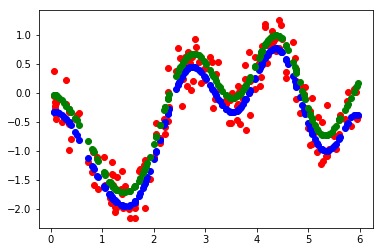

In [62]:
plt.plot(X,Y, 'ro')
plt.plot(X, f_25, 'bo')
plt.plot(X, f_975, 'go')

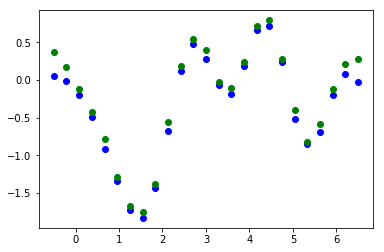

In [69]:
# plt.plot(X,Y, 'ro')
plt.plot(X_star, f_star_25/10, 'bo')
plt.plot(X_star, f_star_975/10, 'go')

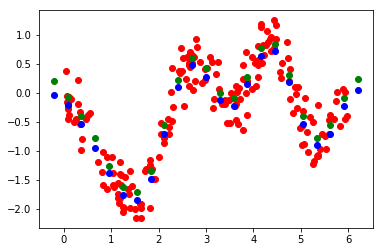

In [72]:
plt.plot(X,Y, 'ro')
plt.plot(X_star[1:-1], y_star_25[1:-1]/10, 'bo')
plt.plot(X_star[1:-1], y_star_975[1:-1]/10, 'go')

In [73]:
print("Mean difference for f between 2.5 and 97.5 percentile: %.3f"%np.mean(f_975/10 - f_25/10))

Mean difference for f between 2.5 and 97.5 percentile: 0.025


In [74]:
print("Mean difference for fstar between 2.5 and 97.5 percentile: %.3f"%np.mean(f_star_975/10 - f_star_25/10))

Mean difference for fstar between 2.5 and 97.5 percentile: 0.101


In [24]:
print("Mean difference for fstar between 2.5 and 97.5 percentile: %.3f"%np.mean(y_star_975 - y_star_25))

Mean difference for fstar between 2.5 and 97.5 percentile: 1.644


In [15]:
# print(fit_gpr_rff)

In [26]:
print(K_samples.shape)

NameError: name 'K_samples' is not defined

In [18]:
K_sample799 = K_samples[-100,:,:]

In [21]:
print(K_sample799.shape)
# print(K_sample799[10,7])

(200, 200)
